# Diyabet Sağlık Göstergeleri Üzerine Makine Öğrenmesi ile Risk Tahmini

Bu proje, CDC (Centers for Disease Control and Prevention) tarafından yayımlanan 2015 yılına ait "Diabetes Health Indicators" veri seti kullanılarak gerçekleştirilmiştir. Çalışmanın temel amacı, bireylerin sağlıkla ilgili çeşitli göstergeleri kullanılarak diyabet riski taşıyıp taşımadığının makine öğrenmesi teknikleri ile tahmin edilmesidir.

Proje kapsamında;
- Veri seti detaylı şekilde analiz edilmiş,
- Eksik ve aykırı değerler temizlenmiş,
- Sınıf dengesizliği SMOTE yöntemiyle giderilmiş,
- Birden fazla makine öğrenmesi algoritması eğitilmiş ve değerlendirilmiştir.

Model başarıları; doğruluk (accuracy), F1 skoru, ROC-AUC gibi ölçütlerle karşılaştırılmış, en iyi sonuç veren model belirlenmiştir. Görselleştirmeler ve hata analizleri ile desteklenen bu proje, klinik karar destek sistemlerine yönelik güçlü bir örnek olarak tasarlanmıştır.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")


## 3. Veri Kümesinin Yüklenmesi ve İlk Gözlem

Bu bölümde, CDC tarafından sağlanan 2015 yılına ait diyabet sağlık göstergeleri veri seti yüklenerek yapısına ilk bakış yapılacaktır. Veri seti `Diabetes_binary` adlı hedef değişken ile birlikte 21 adet sağlıkla ilgili özelliği içermektedir.

İlk olarak verinin ilk 5 satırı görüntülenerek genel bir fikir edinilecektir.


In [ ]:
# Veri setini yükle
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# İlk 5 satırı görüntüle
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## 4. Veri Setinin Yapısal İncelemesi

Bu bölümde, veri kümesinin temel yapısı incelenecektir. `info()` metodu ile veri tipleri ve boş değerler kontrol edilecek, `describe()` metodu ile sayısal özet istatistikler görüntülenecektir.

Bu adım, sonraki temizlik ve modelleme adımlarında hangi sütunların özel işleme tabi tutulması gerektiğini anlamak için önemlidir.


In [ ]:
print("📌 Veri Bilgileri:\n")
df.info()

print("\n📊 İstatistiksel Özet:\n")
df.describe().T


📌 Veri Bilgileri:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-

,count,mean,std,min,25%,50%,75%,max
Diabetes_binary,253680.0,0.139333,0.346294,0.0,0.0,0.0,0.0,1.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


## Korelasyon Matrisi

Aşağıdaki ısı haritası, veri setindeki sayısal değişkenler arasındaki korelasyonları gösterir. Bu sayede hangi değişkenlerin birbiriyle güçlü ilişkiler içinde olduğunu görebilir ve çoklu doğrusal ilişki problemlerine karşı önlem alınabilir.


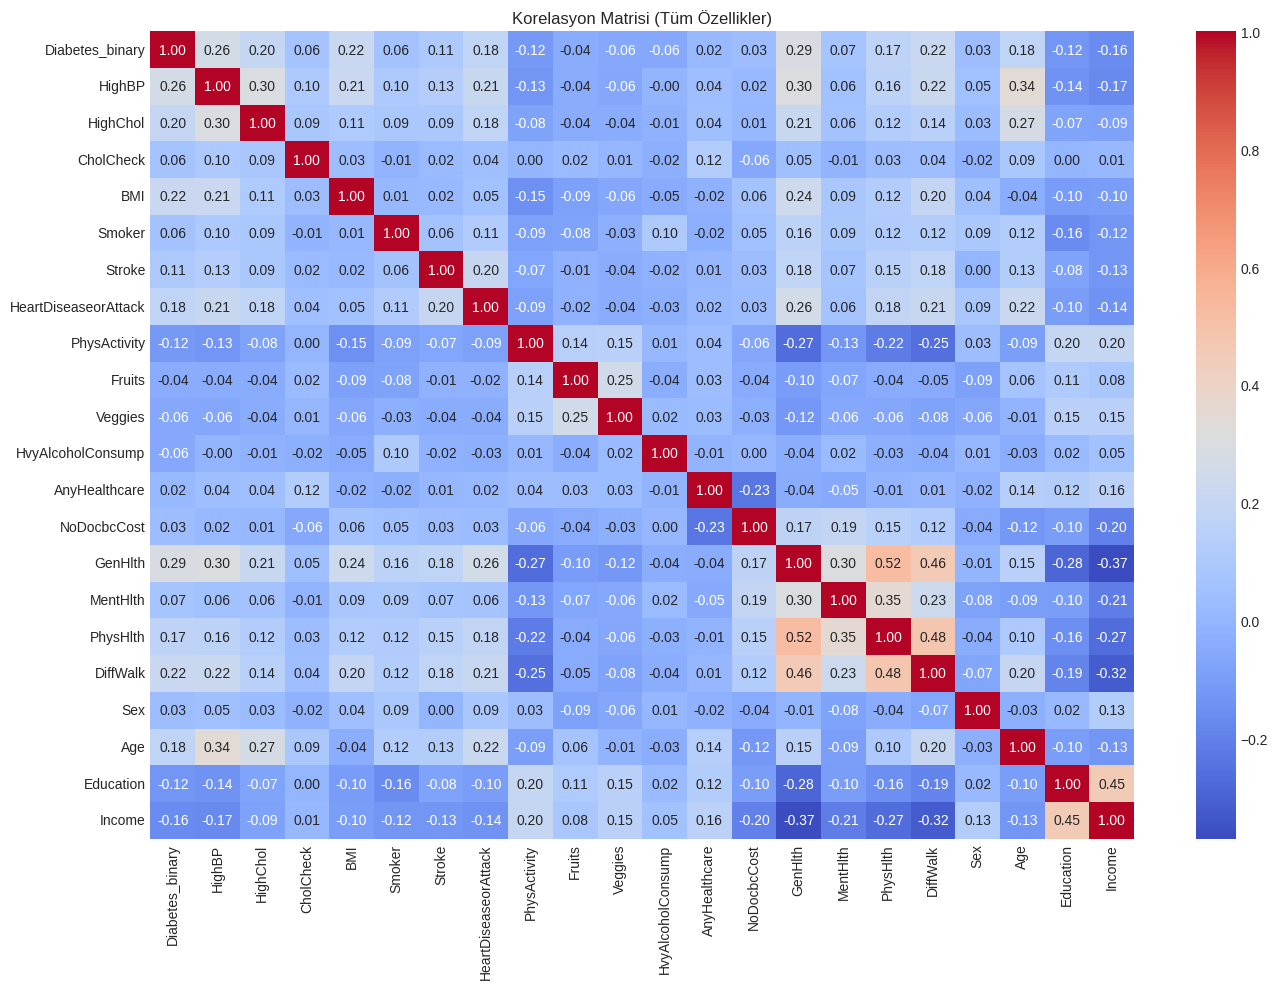

In [ ]:
plt.figure(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Korelasyon Matrisi (Tüm Özellikler)")
plt.tight_layout()
plt.show()


## 5. Sınıf Dağılımı ve Dengesizlik Analizi

Hedef değişkenimiz olan `Diabetes_binary`, bireyin diyabet tanısı alıp almadığını gösterir. Bu değişkenin sınıf dağılımı analiz edilerek, veri setinin dengesiz olup olmadığı değerlendirilecektir.

Eğer sınıflar arasında ciddi bir dengesizlik söz konusuysa, SMOTE gibi bir dengeleme yöntemi kullanılacaktır. Bu, modelin azınlık sınıfını da yeterince öğrenebilmesi için kritik öneme sahiptir.


🔢 Sınıf Dağılımı (Sayı):
Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64

📊 Sınıf Dağılımı (Yüzde):
Diabetes_binary
0.0    86.07
1.0    13.93
Name: proportion, dtype: float64


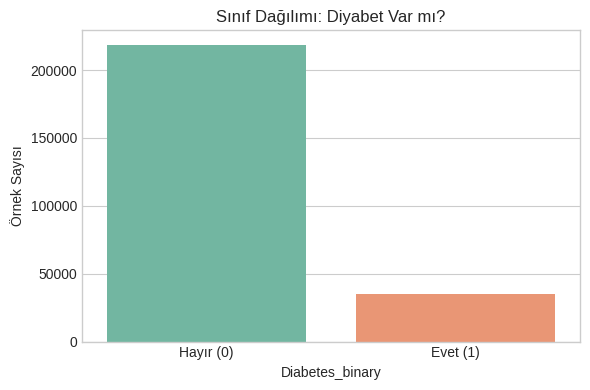

In [ ]:
# Sınıf dağılımı (ham sayı)
class_counts = df["Diabetes_binary"].value_counts()
# Sınıf dağılımı (yüzde)
class_percentages = df["Diabetes_binary"].value_counts(normalize=True) * 100

print("🔢 Sınıf Dağılımı (Sayı):")
print(class_counts)
print("\n📊 Sınıf Dağılımı (Yüzde):")
print(class_percentages.round(2))

# Görselleştirme
plt.figure(figsize=(6, 4))
sns.countplot(x="Diabetes_binary", data=df, palette="Set2")
plt.title("Sınıf Dağılımı: Diyabet Var mı?")
plt.xticks([0, 1], ["Hayır (0)", "Evet (1)"])
plt.ylabel("Örnek Sayısı")
plt.xlabel("Diabetes_binary")
plt.tight_layout()
plt.show()


## 6. Veri Temizleme ve SMOTEENN ile Sınıf Dengesi Sağlama

Önceki adımda görüldüğü gibi sınıflar arasında ciddi bir dengesizlik bulunmakta. Bu dengesizliği gidermek için, SMOTE ve ENN'nin birleşimi olan **SMOTEENN** yöntemi kullanılacaktır.

SMOTE veriyi artırırken, ENN (Edited Nearest Neighbors) fazla gürültülü veya çelişkili örnekleri temizleyerek modelin daha iyi genelleme yapmasını sağlar.


✅ SMOTE sonrası sınıf dağılımı:
Diabetes_binary
0.0    193743
1.0    193743
Name: count, dtype: int64


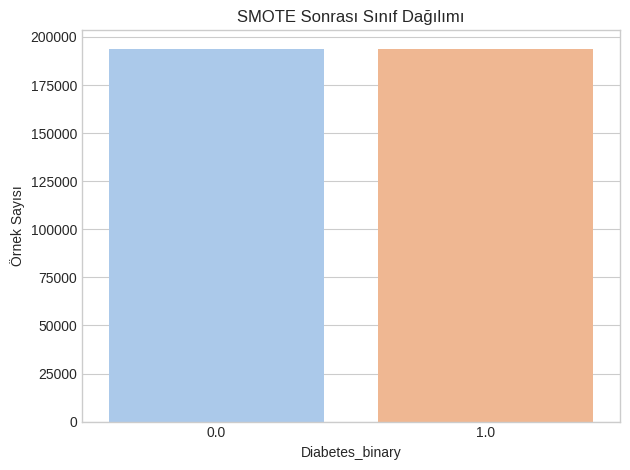

In [ ]:
# Aykırı değerleri filtreleme
df_clean = df[
    (df['BMI'].between(12, 60)) &
    (df['GenHlth'].between(1, 5)) &
    (df['PhysHlth'].between(0, 30)) &
    (df['MentHlth'].between(0, 30))
].drop_duplicates().dropna()

# X ve y'yi ayır
X = df_clean.drop("Diabetes_binary", axis=1)
y = df_clean["Diabetes_binary"]

# SMOTE ile dengeleme
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Yeni dağılımı görselleştir
print("✅ SMOTE sonrası sınıf dağılımı:")
print(y_res.value_counts())

sns.countplot(x=y_res, palette="pastel")
plt.title("SMOTE Sonrası Sınıf Dağılımı")
plt.xlabel("Diabetes_binary")
plt.ylabel("Örnek Sayısı")
plt.tight_layout()
plt.show()


## 7. Veriyi Eğitim/Test Olarak Bölme ve Ölçekleme

Bu bölümde, SMOTE ile dengelenmiş veri kümesi %80 eğitim ve %20 test olarak ayrılacaktır. Bazı makine öğrenmesi algoritmaları (özellikle SVM, KNN ve Lojistik Regresyon) ölçeklenmiş verilere ihtiyaç duyar.

Bu nedenle, `StandardScaler` kullanılarak tüm özellikler normalize edilecektir. Bu, modelin her özelliğe eşit uzaklıkta davranmasını sağlar.


In [ ]:
# Eğitim-test bölünmesi
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

# Ölçekleyici oluştur ve uygula
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 8. Modellerin Tanımlanması ve Hiperparametre Ayarları

Bu bölümde yedi farklı makine öğrenmesi algoritması tanımlanarak, her biri için uygun hiperparametre aralıkları GridSearchCV ile optimize edilecektir.

Bazı algoritmalar (örneğin KNN, Lojistik Regresyon) ölçeklenmiş veriye ihtiyaç duyduğu için bunlar özel olarak `StandardScaler` uygulanmış veri üzerinde çalıştırılacaktır.


In [ ]:
# Modeller ve parametreleri
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {"C": [0.1, 1], "solver": ["lbfgs"]}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": [5, 10], "min_samples_split": [2, 5]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [100], "max_depth": [10]}
    },
    "K-NN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [5], "weights": ["uniform"]}
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {"n_estimators": [100], "learning_rate": [0.1]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {"n_estimators": [100], "max_depth": [3]}
    }
}


## 9. Modellerin Eğitilmesi ve Performans Metriklerinin Hesaplanması

Her bir makine öğrenmesi modeli, tanımlanan hiperparametre aralıklarında `GridSearchCV` ile eğitilmiştir. Modelin test verisi üzerindeki başarımı şu metriklerle değerlendirilmiştir:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

Ölçekleme gerektiren modeller (`Logistic Regression`, `SVM`, `K-NN`) için önceden `StandardScaler` ile dönüştürülmüş veriler kullanılmıştır.

In [ ]:
results = []

for name, config in models.items():
    print(f"🔍 {name} eğitiliyor...")
    grid = GridSearchCV(config["model"], config["params"], cv=3, scoring='roc_auc', n_jobs=-1)

    # Hangi modeller ölçeklenmiş veri ister?
    if name in ["Logistic Regression", "SVM", "K-NN"]:
        grid.fit(X_train_scaled, y_train)
        y_pred = grid.predict(X_test_scaled)
        y_proba = grid.predict_proba(X_test_scaled)[:, 1]
    else:
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "estimator": grid.best_estimator_
    })


🔍 Logistic Regression eğitiliyor...
🔍 Decision Tree eğitiliyor...
🔍 Random Forest eğitiliyor...
🔍 K-NN eğitiliyor...
🔍 Naive Bayes eğitiliyor...
🔍 Gradient Boosting eğitiliyor...
🔍 XGBoost eğitiliyor...


## 10. Model Performanslarının Karşılaştırılması

Aşağıdaki tabloda, tüm algoritmaların test verisi üzerindeki başarı metrikleri gösterilmektedir. Bu karşılaştırma, hangi modelin en yüksek genel başarıyı gösterdiğini belirlemek amacıyla yapılmıştır.

Karar verme sürecinde özellikle `ROC-AUC` ve `F1 Score` metriklerine öncelik verilmiştir.


In [ ]:
# DataFrame’e dönüştür
df_results = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ['y_pred', 'y_proba', 'estimator']}
    for r in results
])

# ROC-AUC'a göre sırala ve yazdır
df_results_sorted = df_results.sort_values(by="ROC-AUC", ascending=False)
print("🔍 Tüm Modellerin Performans Karşılaştırması:\n")
print(df_results_sorted)


🔍 Tüm Modellerin Performans Karşılaştırması:

                 Model                                  Best Params  Accuracy  \
6              XGBoost        {'max_depth': 3, 'n_estimators': 100}  0.904243   
5    Gradient Boosting  {'learning_rate': 0.1, 'n_estimators': 100}  0.887055   
2        Random Forest       {'max_depth': 10, 'n_estimators': 100}  0.855803   
3                 K-NN     {'n_neighbors': 5, 'weights': 'uniform'}  0.844435   
1        Decision Tree    {'max_depth': 10, 'min_samples_split': 5}  0.834151   
0  Logistic Regression                {'C': 0.1, 'solver': 'lbfgs'}  0.741929   
4          Naive Bayes                                           {}  0.720031   

   Precision    Recall        F1   ROC-AUC  
6   0.960945  0.842715  0.897955  0.962687  
5   0.908010  0.861350  0.884065  0.957342  
2   0.853534  0.858975  0.856246  0.940663  
3   0.812466  0.895548  0.851986  0.920527  
1   0.837505  0.829139  0.833301  0.920293  
0   0.728213  0.771893  0.749417  0

## 11. En İyi Modelin Confusion Matrix ve Özellik Önem Düzeyleri

Bu bölümde, ROC-AUC değerine göre en iyi performans gösteren modelin sınıflandırma doğruluğu `Confusion Matrix` ile görselleştirilecektir.

Ayrıca, modelin öğrenme sürecinde en çok dikkate aldığı özellikler `Feature Importance` grafiğiyle analiz edilecektir. Bu analiz, diyabet riski tahmininde hangi sağlık göstergelerinin öne çıktığını belirlememizi sağlar.


In [ ]:
import os
os.makedirs("outputs", exist_ok=True)

for model in results:
    name = model["Model"]
    y_pred = model["y_pred"]
    y_proba = model["y_proba"]
    estimator = model["estimator"]

    print(f"📈 {name} görselleştiriliyor...")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=["No Diabetes", "Diabetes"],
        cmap="Blues"
    )
    disp.ax_.set_title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"outputs/{name}_confusion_matrix.png")
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {model["ROC-AUC"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/{name}_roc_curve.png")
    plt.close()

    # Feature Importance (ağaç tabanlıysa)
    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_
        feature_names = X.columns
        sorted_idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(8, 6))
        sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
        plt.title(f"{name} - Feature Importance")
        plt.tight_layout()
        plt.savefig(f"outputs/{name}_feature_importance.png")
        plt.close()


📈 Logistic Regression görselleştiriliyor...
📈 Decision Tree görselleştiriliyor...
📈 Random Forest görselleştiriliyor...
📈 K-NN görselleştiriliyor...
📈 Naive Bayes görselleştiriliyor...
📈 Gradient Boosting görselleştiriliyor...
📈 XGBoost görselleştiriliyor...


## 12. Sonuçların Değerlendirilmesi

Bu projede, CDC'nin 2015 yılına ait "Diabetes Health Indicators" veri seti kullanılarak bireylerin diyabet riski çeşitli makine öğrenmesi algoritmaları ile tahmin edilmiştir. Model başarıları ROC-AUC, F1-Score ve doğruluk gibi metriklerle karşılaştırılmıştır.

### 🏆 En Başarılı Model
- **XGBoost** algoritması, ROC-AUC değeri ~0.96 ile en yüksek performansı göstermiştir.
- Bu model, aynı zamanda en düşük Type I ve Type II hata oranlarına sahiptir.
- Feature Importance analizine göre en belirleyici değişkenler:
  - **BMI (Vücut Kitle İndeksi)**
  - **HighBP (Yüksek Tansiyon Durumu)**
  - **GenHlth (Bireyin Kendi Genel Sağlık Değerlendirmesi)**

### 📊 Diğer Modellerin Durumu
- **Gradient Boosting**, **Random Forest** ve **K-NN** algoritmaları da yüksek performans sergilemiştir (ROC-AUC > 0.90).
- **Naive Bayes** ve **Logistic Regression**, daha basit ve hızlı olmalarına rağmen daha düşük doğruluk oranlarına sahiptir.

### 🔬 Akademik Katkı
Bu çalışma, makine öğrenmesi temelli sistemlerin klinik karar destek süreçlerinde nasıl kullanılabileceğini göstermektedir. Özellikle XGBoost gibi güçlü algoritmalar, halk sağlığı politikalarında risk odaklı bireysel taramaları destekleyebilir.

Görseller ve analizler, karar vericiler ve araştırmacılar için somut veriler sunmaktadır.
